# Rock-Paper-Scissors Gesture Classification Pipeline

This notebook demonstrates the complete ML pipeline for Rock-Paper-Scissors image classification, including:
- Data preprocessing
- Model creation and training
- Model evaluation with multiple metrics
- Model optimization techniques


In [1]:
# Import necessary libraries
import sys
import os
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras

from preprocessing import ImagePreprocessor
from model import RPSModel
from prediction import Predictor

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")


Libraries imported successfully!
TensorFlow version: 2.20.0
Keras version: 3.12.0


## 1. Data Acquisition and Exploration


In [2]:
# Define data paths
train_dir = '../data/raw/train'
test_dir = '../data/raw/test'

# Check data structure
print("Training data structure:")
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  {class_name}: {num_images} images")

print("\nTest data structure:")
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  {class_name}: {num_images} images")


Training data structure:
  paper: 840 images
  rock: 840 images
  scissors: 840 images

Test data structure:
  paper: 124 images
  rock: 124 images
  scissors: 124 images


## 2. Data Preprocessing


In [3]:
# Initialize preprocessor
preprocessor = ImagePreprocessor(img_size=(150, 150), normalize=True)

# Load training and test data
print("Loading training data...")
X_train, y_train, X_test, y_test = preprocessor.prepare_training_data(train_dir, test_dir)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Get class names
class_names = preprocessor.get_class_names()
print(f"\nClass names: {class_names}")

# Display class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nTraining set class distribution:")
for idx, count in zip(unique, counts):
    print(f"  {class_names[idx]}: {count} images")

unique_test, counts_test = np.unique(y_test, return_counts=True)
print("\nTest set class distribution:")
for idx, count in zip(unique_test, counts_test):
    print(f"  {class_names[idx]}: {count} images")


Loading training data...
Loading training data...
Loading test data...

Training data shape: (2520, 150, 150, 3)
Training labels shape: (2520,)
Test data shape: (372, 150, 150, 3)
Test labels shape: (372,)

Class names: [np.str_('paper'), np.str_('rock'), np.str_('scissors')]

Training set class distribution:
  paper: 840 images
  rock: 840 images
  scissors: 840 images

Test set class distribution:
  paper: 124 images
  rock: 124 images
  scissors: 124 images


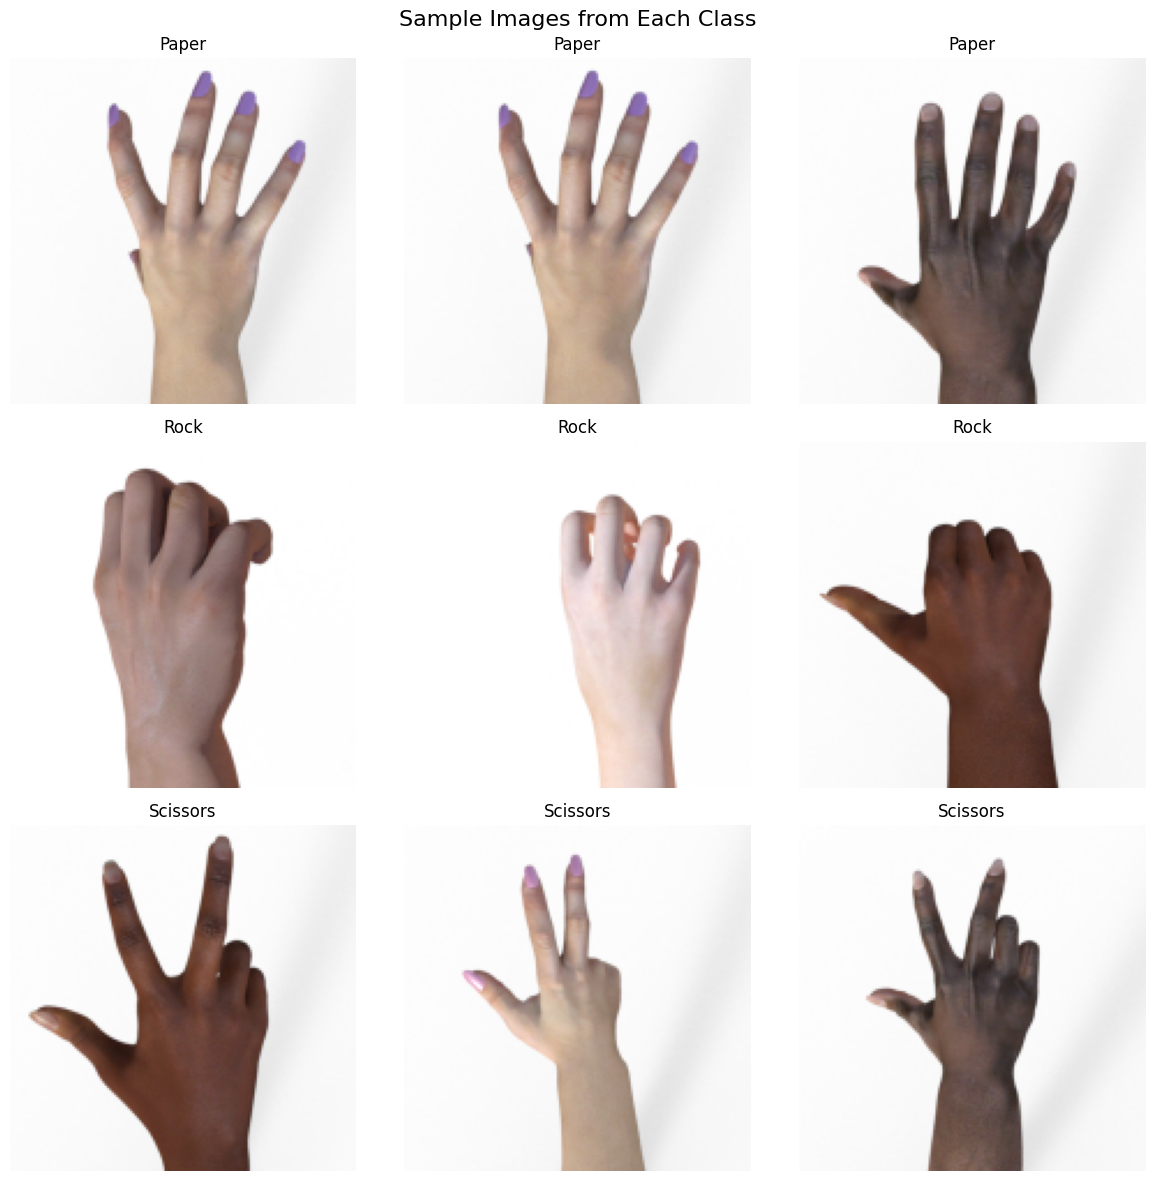

In [4]:
# Visualize sample images
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Sample Images from Each Class', fontsize=16)

for class_idx, class_name in enumerate(class_names):
    # Find indices for this class
    class_indices = np.where(y_train == class_idx)[0]
    
    # Display 3 random samples
    sample_indices = np.random.choice(class_indices, 3, replace=False)
    
    for i, idx in enumerate(sample_indices):
        axes[class_idx, i].imshow(X_train[idx])
        axes[class_idx, i].set_title(f'{class_name.capitalize()}')
        axes[class_idx, i].axis('off')

plt.tight_layout()
plt.show()


## 3. Model Creation and Training


In [5]:
# Create model instance
rps_model = RPSModel(img_size=(150, 150), num_classes=3)

# Build model with transfer learning (MobileNetV2)
print("Building model with transfer learning...")
model = rps_model.build_model(use_transfer_learning=True)

# Display model architecture
model.summary()


Building model with transfer learning...


/Users/abizera/Documents/ALU/ML/ml-pipeline/rps-gesture-pipeline/notebook/../src/model.py:48: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Train the model with optimization techniques
print("Training model...")
print("Using optimization techniques:")
print("  - Early Stopping: Prevents overfitting")
print("  - Learning Rate Reduction: Adapts learning rate during training")
print("  - Model Checkpointing: Saves best model")
print("  - Transfer Learning: Uses MobileNetV2 pre-trained weights")

history = rps_model.train(
    X_train, y_train,
    X_val=X_test,
    y_val=y_test,
    epochs=20,
    batch_size=32,
    use_early_stopping=True,
    use_reduce_lr=True
)


Training model...
Using optimization techniques:
  - Early Stopping: Prevents overfitting
  - Learning Rate Reduction: Adapts learning rate during training
  - Model Checkpointing: Saves best model
  - Transfer Learning: Uses MobileNetV2 pre-trained weights
Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8331 - loss: 0.3901
Epoch 1: val_loss improved from None to 0.30084, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.9425 - loss: 0.1462 - val_accuracy: 0.9140 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9970 - loss: 0.0119
Epoch 2: val_loss improved from 0.30084 to 0.23656, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9984 - loss: 0.0083 - val_accuracy: 0.9301 - val_loss: 0.2366 - learning_rate: 0.0010
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9993 - loss: 0.0060
Epoch 3: val_loss did not improve from 0.23656
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9992 - loss: 0.0050 - val_accuracy: 0.9247 - val_loss: 0.2606 - learning_rate: 0.0010
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 4: val_loss did not improve from 0.23656
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9220 - val_loss: 0.2628 - learning_rate: 0.0010
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 0.0026
Epoch 5: val_loss improved from 0.23656 to 0.20316, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9274 - val_loss: 0.2032 - learning_rate: 0.0010
Epoch 6/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 6: val_loss did not improve from 0.20316
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 9.3732e-04 - val_accuracy: 0.9194 - val_loss: 0.2874 - learning_rate: 0.0010
Epoch 7/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9974 - loss: 0.0073
Epoch 7: val_loss did not improve from 0.20316
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.9964 - loss: 0.0094 - val_accuracy: 0.9301 - val_loss: 0.2705 - learning_rate: 0.0010
Epoch 8/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 8: val_loss improved from 0.20316 to 0.19873, saving model to models/best_model.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9301 - val_loss: 0.1987 - learning_rate: 0.0010
Epoch 9/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 8.8972e-04
Epoch 9: val_loss did not improve from 0.19873
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9032 - val_loss: 0.3014 - learning_rate: 0.0010
Epoch 10/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 1.0000 - loss: 4.7561e-04
Epoch 10: val_loss did not improve from 0.19873
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 1.0000 - loss: 4.1905e-04 - val_accuracy: 0.9167 - val_loss: 0.2921 - learning_rate: 0.0010
Epoch 11/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.9103e-04
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 11: val_loss did not improve from 0.19873
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 1.0000 - loss: 2.3604e

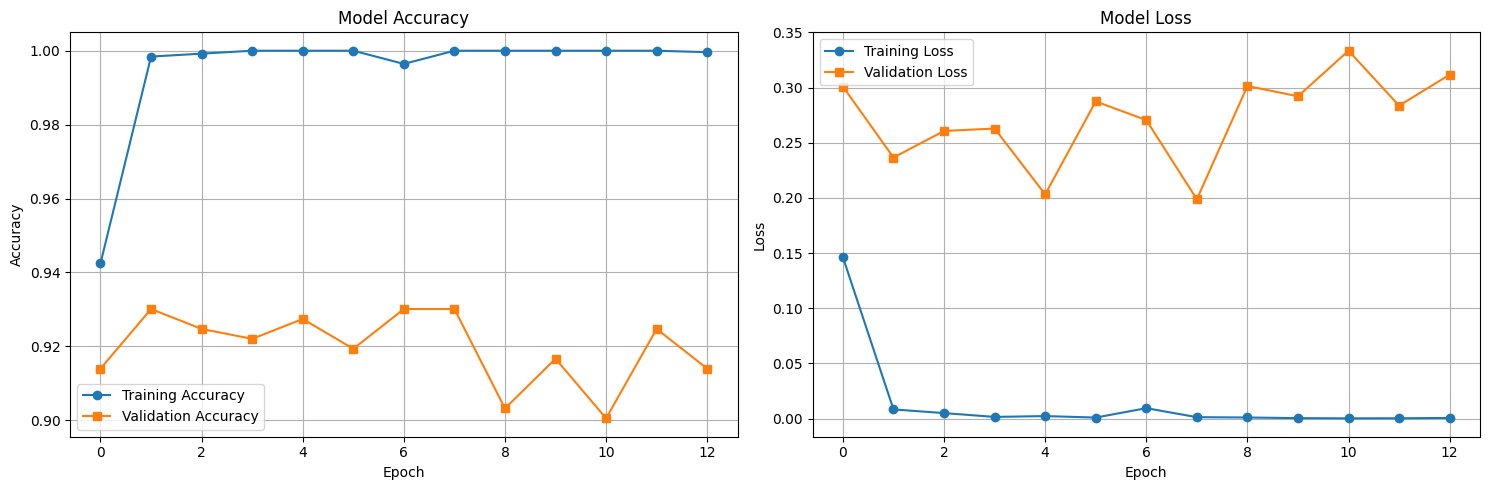

In [7]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
axes[0].plot(history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history['loss'], label='Training Loss', marker='o')
axes[1].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 4. Model Evaluation


In [8]:
# Evaluate model on test set
print("Evaluating model on test set...")
metrics = rps_model.evaluate(X_test, y_test)

print("\n" + "="*50)
print("MODEL EVALUATION METRICS")
print("="*50)
print(f"Accuracy:  {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1 Score:  {metrics['f1_score']:.4f}")
print(f"Loss:      {metrics['loss']:.4f}")
print("="*50)


Evaluating model on test set...

MODEL EVALUATION METRICS
Accuracy:  0.9301 (93.01%)
Precision: 0.9323
Recall:    0.9301
F1 Score:  0.9286
Loss:      0.1987


In [9]:
# Get detailed predictions
y_pred_proba = rps_model.model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

       paper       0.96      0.82      0.89       124
        rock       0.91      0.98      0.95       124
    scissors       0.92      0.98      0.95       124

    accuracy                           0.93       372
   macro avg       0.93      0.93      0.93       372
weighted avg       0.93      0.93      0.93       372



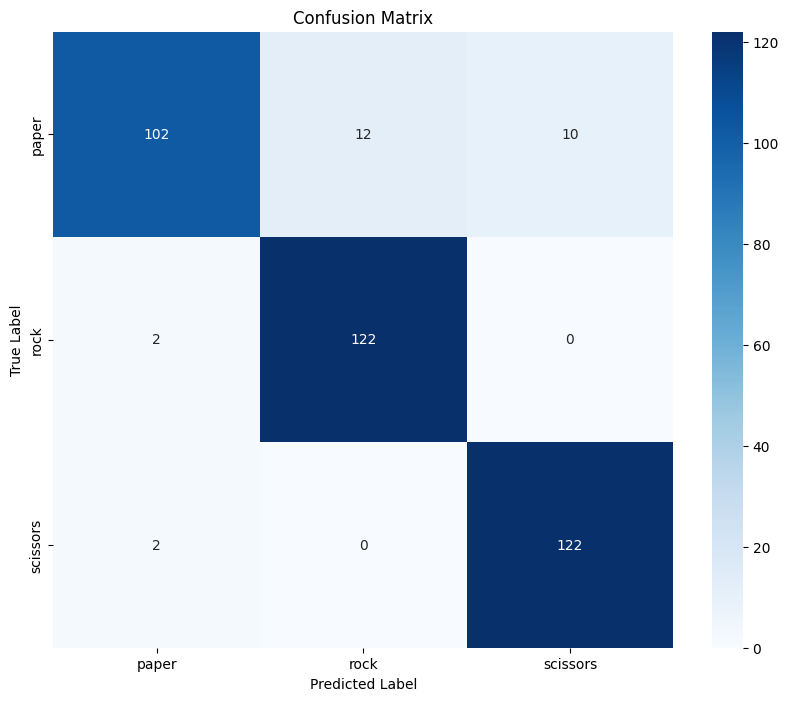


Per-Class Metrics:

Paper:
  Precision: 0.9623
  Recall:    0.8226
  F1 Score:  0.8870

Rock:
  Precision: 0.9104
  Recall:    0.9839
  F1 Score:  0.9457

Scissors:
  Precision: 0.9242
  Recall:    0.9839
  F1 Score:  0.9531


In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate per-class metrics
print("\nPer-Class Metrics:")
for i, class_name in enumerate(class_names):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{class_name.capitalize()}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")


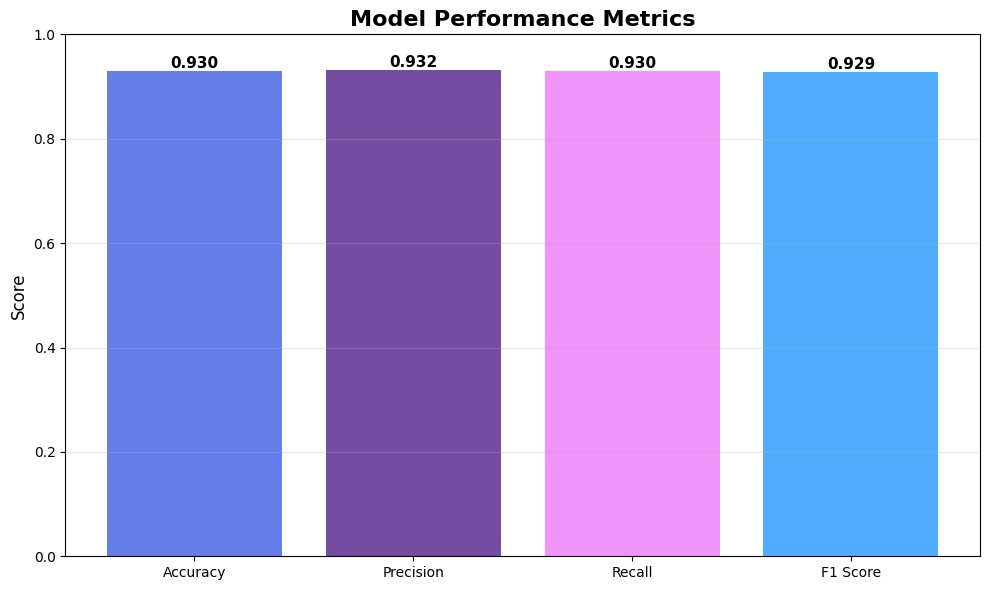

In [11]:
# Visualize metrics comparison
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]
}

df_metrics = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(df_metrics['Metric'], df_metrics['Value'], color=['#667eea', '#764ba2', '#f093fb', '#4facfe'])
plt.title('Model Performance Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Model Predictions on Sample Images


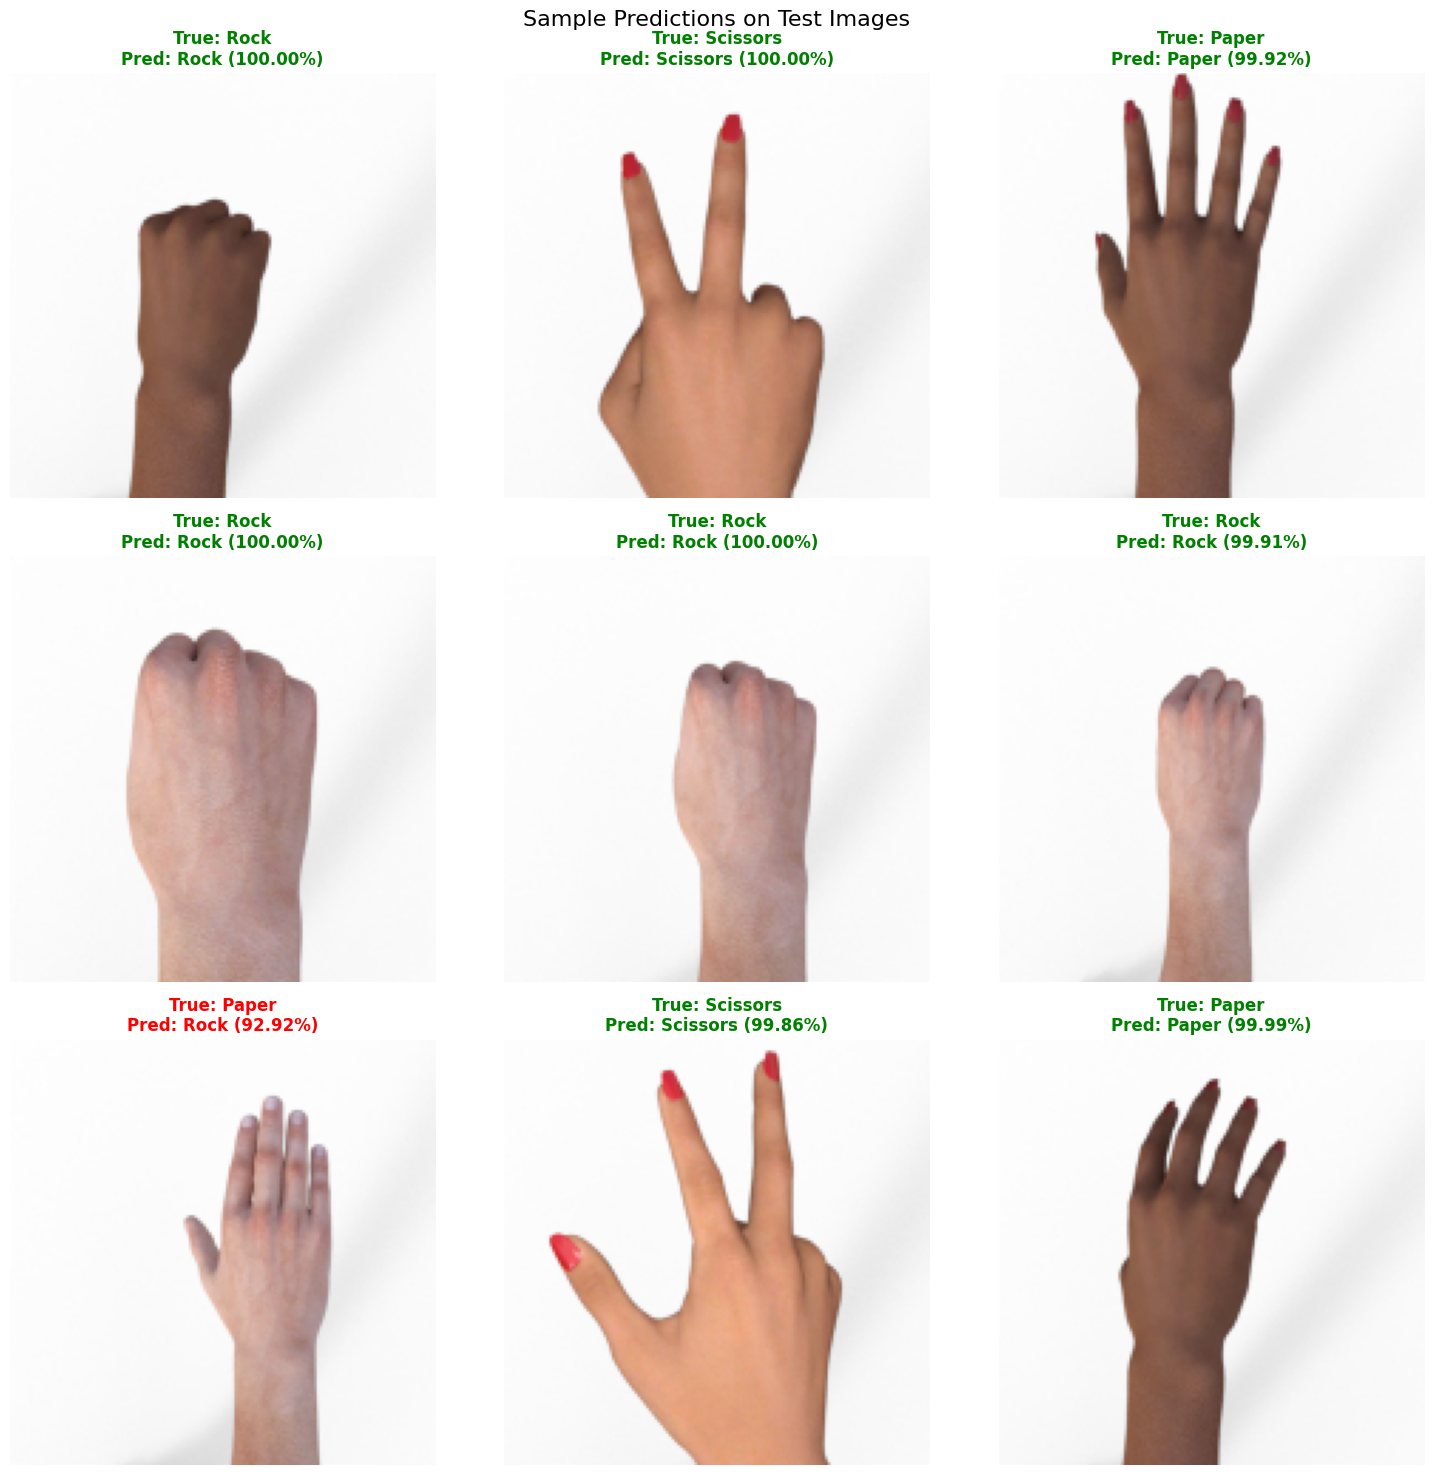

In [12]:
# Test predictions on sample images
predictor = Predictor(rps_model.model, preprocessor, class_names)

# Select random test images
num_samples = 9
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Sample Predictions on Test Images', fontsize=16)

for idx, ax in zip(sample_indices, axes.flat):
    # Get prediction
    result = predictor.predict_from_array(X_test[idx:idx+1])
    
    # Display image
    ax.imshow(X_test[idx])
    
    # Get true label
    true_label = class_names[y_test[idx]]
    pred_label = result['predicted_class']
    confidence = result['confidence']
    
    # Color: green if correct, red if incorrect
    color = 'green' if true_label == pred_label else 'red'
    
    ax.set_title(f'True: {true_label.capitalize()}\nPred: {pred_label.capitalize()} ({confidence:.2%})', 
                 color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()


## 6. Save Model


In [13]:
# Save the trained model
model_path = '../models/rps_model.h5'
os.makedirs('../models', exist_ok=True)
rps_model.save_model(model_path)

print(f"Model saved successfully to {model_path}")
print(f"\nModel Summary:")
print(f"  - Architecture: MobileNetV2 (Transfer Learning)")
print(f"  - Input Size: 150x150x3")
print(f"  - Number of Classes: 3")
print(f"  - Test Accuracy: {metrics['accuracy']:.4f}")
print(f"  - Test F1 Score: {metrics['f1_score']:.4f}")


Model saved to ../models/rps_model.h5
Model saved successfully to ../models/rps_model.h5

Model Summary:
  - Architecture: MobileNetV2 (Transfer Learning)
  - Input Size: 150x150x3
  - Number of Classes: 3
  - Test Accuracy: 0.9301
  - Test F1 Score: 0.9286
